In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

# Read Source Files

In [2]:
df_train=pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")
sample_sub=pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")
df_train_orig=pd.read_csv("/kaggle/input/playgrounds4e06originaldata/original.csv")
df_train_orig.columns=df_train.columns
#
df_train=pd.concat([df_train,df_train_orig],axis=0)
#
df_train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


# Exploratory Data Analysis

## Features

In [3]:
binary_cols=[]
#
for c in df_train.columns:
    if df_train[c].nunique() == 2:
        binary_cols.append(c)
#
num_cols = list(df_train.columns[np.where(df_train.dtypes != "object")[0]].drop(['id']).drop(binary_cols))

In [4]:
print("num_cols: ",num_cols)
print("-"*70)
print("binary_cols: ",binary_cols)

num_cols:  ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
----------------------------------------------------------------------
binary_cols:  ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'T

## Concise summary of the data

In [5]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 80942 entries, 0 to 4423
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              80942 non-null  int64  
 1   Marital status                                  80942 non-null  int64  
 2   Application mode                                80942 non-null  int64  
 3   Application order                               80942 non-null  int64  
 4   Course                                          80942 non-null  int64  
 5   Daytime/evening attendance                      80942 non-null  int64  
 6   Previous qualification                          80942 non-null  int64  
 7   Previous qualification (grade)                  80942 non-null  float64
 8   Nacionality                                     80942 non-null  int64  
 9   Mother's qualification                       

## Statistical summary

In [6]:
df_train.describe()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,...,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000,80942.000000
mean,36288.354661,1.115577,16.197326,1.648971,8993.380668,0.913975,3.708989,132.391585,1.261941,19.822564,...,0.062316,0.159176,5.949742,7.279768,4.030627,9.659104,0.067246,11.522844,1.228208,-0.076391
std,22988.677378,0.452426,16.737628,1.234530,1818.900599,0.280402,8.720782,11.126395,3.675890,15.410691,...,0.429133,1.016847,1.664669,3.533806,2.788397,5.529912,0.483030,2.653953,1.397932,2.252464
min,0.000000,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,15811.250000,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,...,0.000000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,36046.500000,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,56281.750000,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,...,0.000000,0.000000,6.000000,9.000000,6.000000,13.250000,0.000000,12.700000,2.600000,1.790000
max,76517.000000,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


## Plot Functions

In [7]:
def plot_numerics(data):
    numeric_columns = data.columns
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()

        # Histogram
        #sns.histplot(data[column], bins=10, kde=True, color='skyblue', ax=ax[0])
        sns.histplot(data[column],kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)

        # Box plot
        sns.boxplot(x=data[column], color='lightgreen', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)

        plt.tight_layout()
        plt.show()

## Plot Target Values

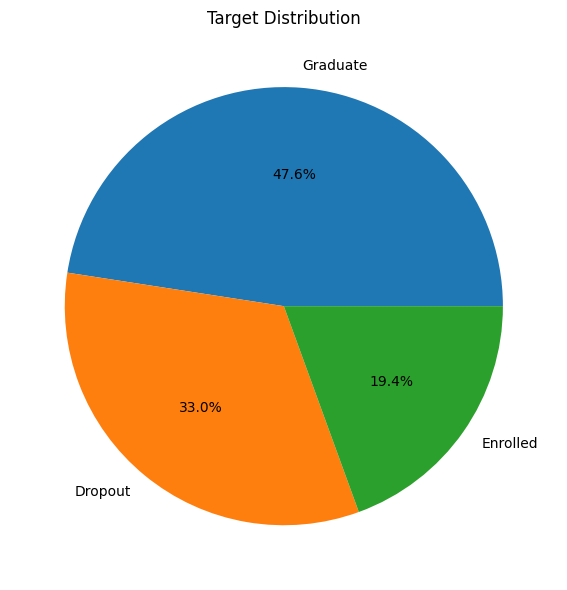

In [8]:
plt.subplots(figsize=(6,6))
temp = df_train['Target'].value_counts()
plt.pie(temp.values, labels=temp.index.values,autopct='%1.1f%%')
plt.title("Target Distribution")
plt.tight_layout()
plt.show()

## Plot Binary Columns

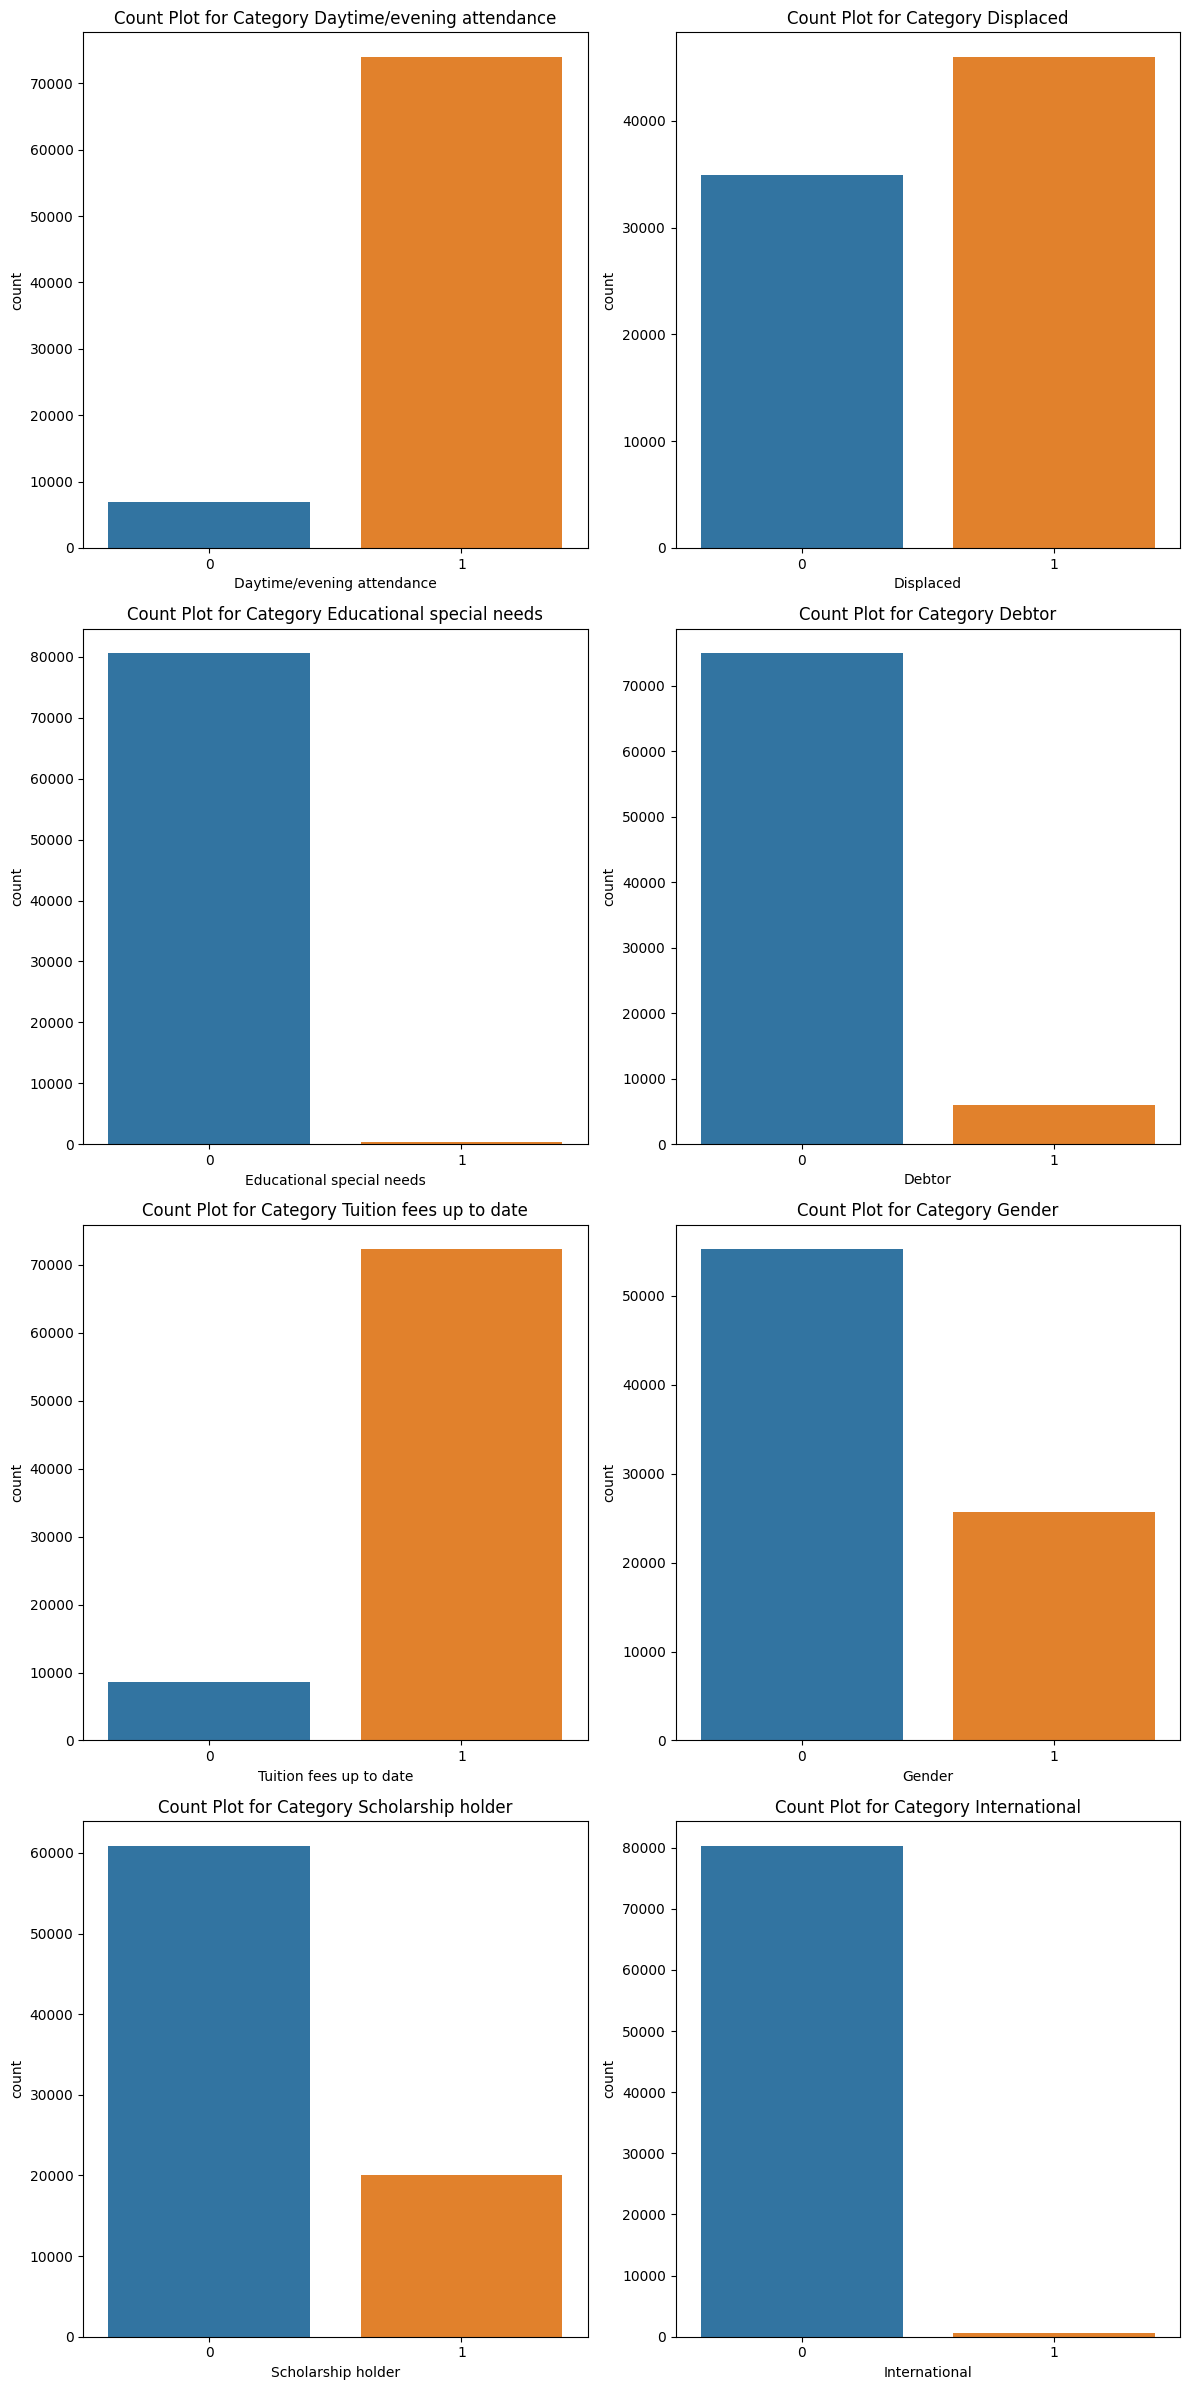

In [9]:
n_cols = 2  
n_rows = int(np.ceil(len(binary_cols) / n_cols))  
#
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
axs = axs.flatten() if n_rows > 1 else [axs]
#
for i, category in enumerate(binary_cols):
    sns.countplot(x=category, data=df_train, ax=axs[i])
    axs[i].set_title(f'Count Plot for Category {category}')
    plt.tight_layout()
    
plt.show()

## Plot Curricular Features

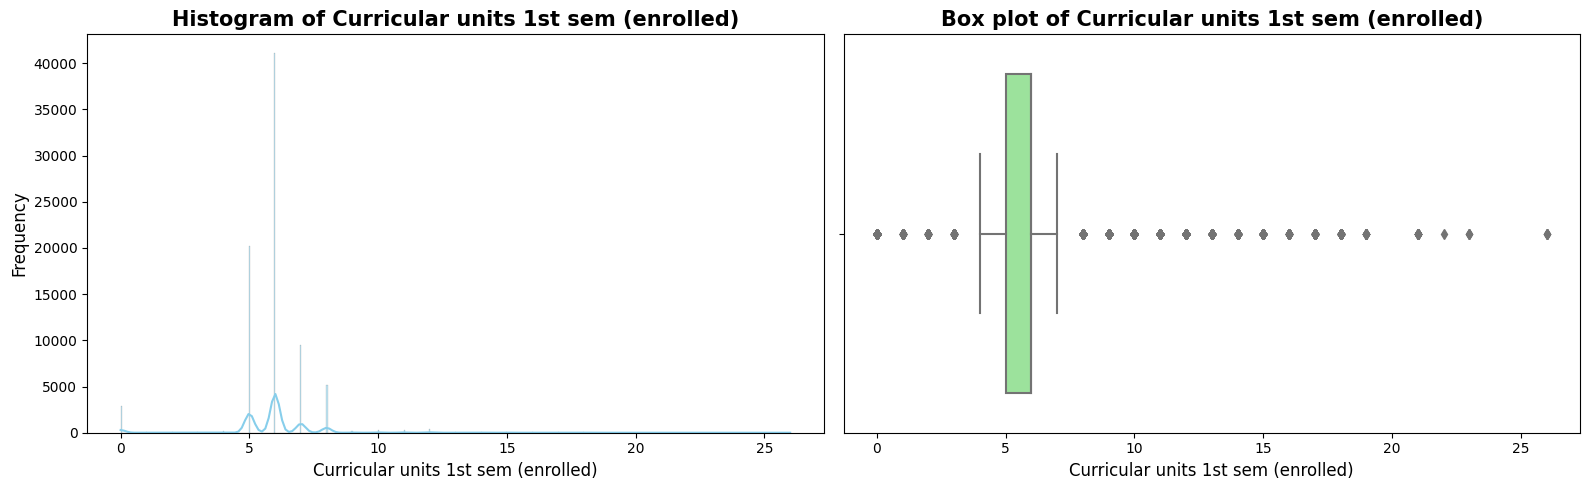

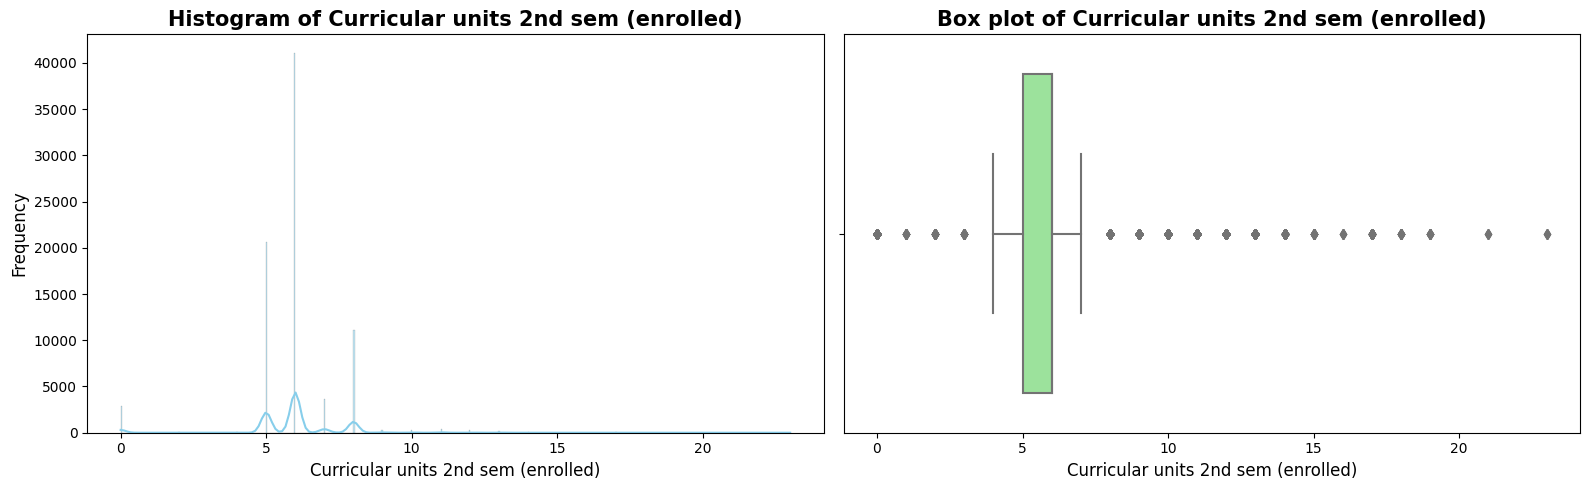

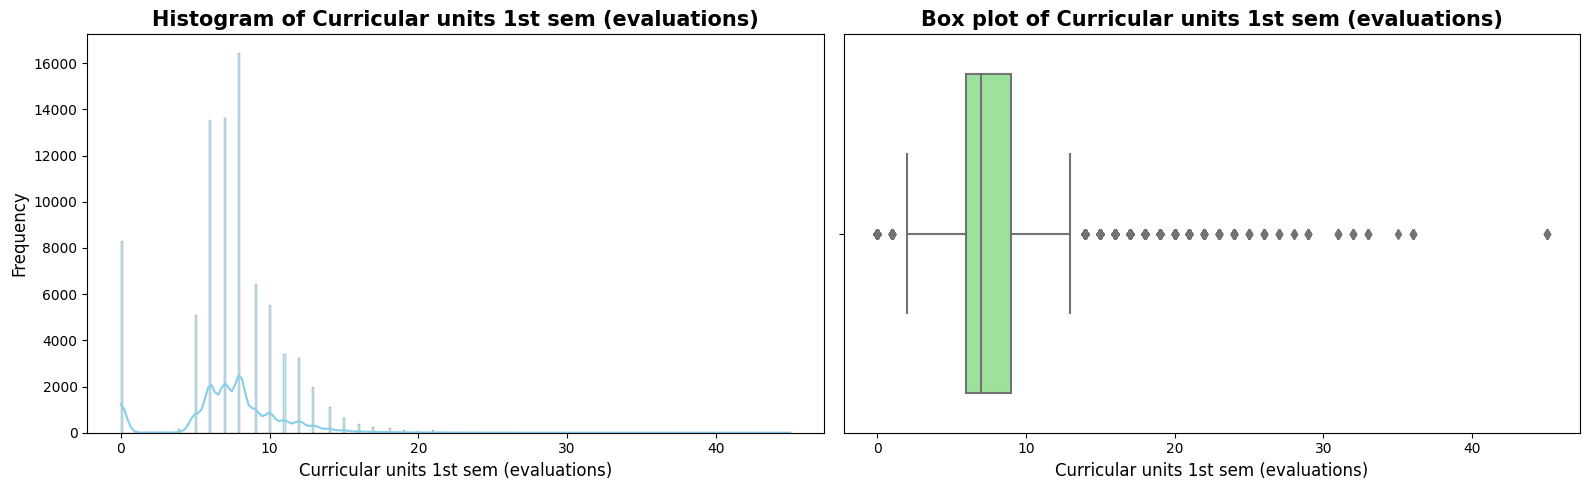

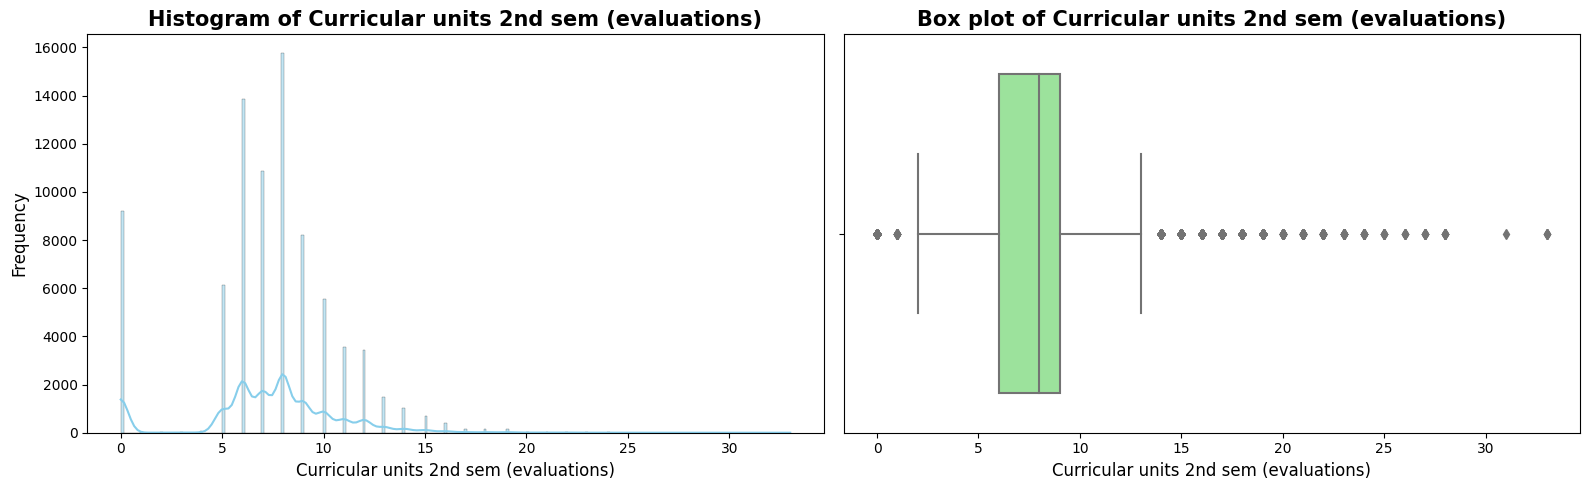

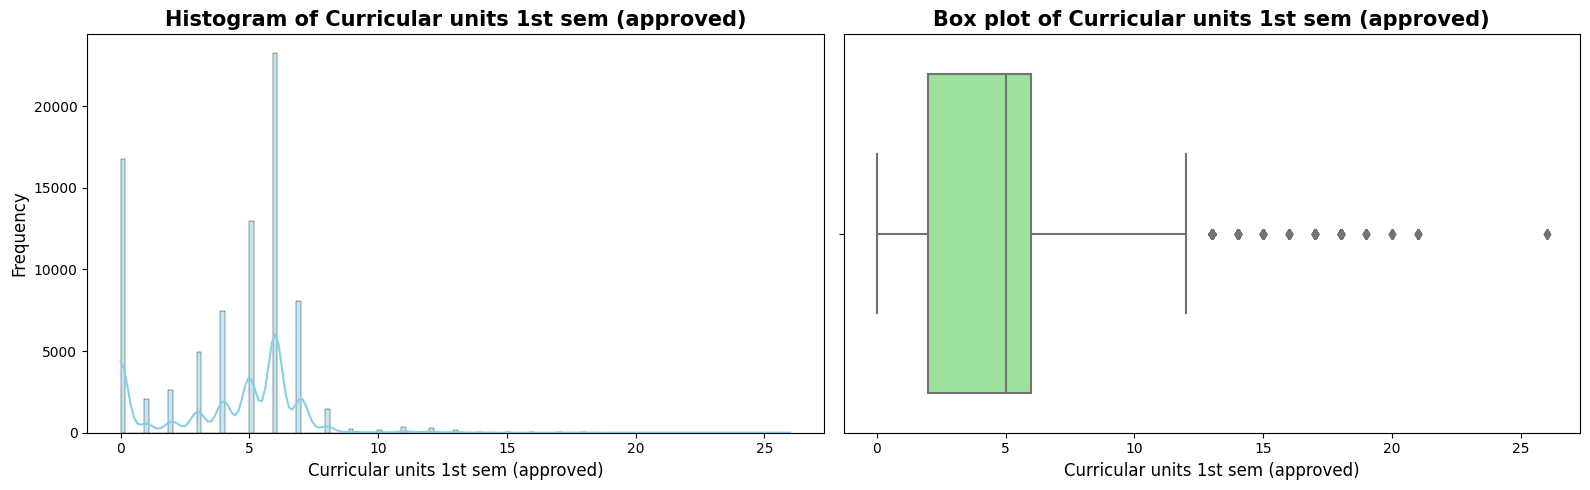

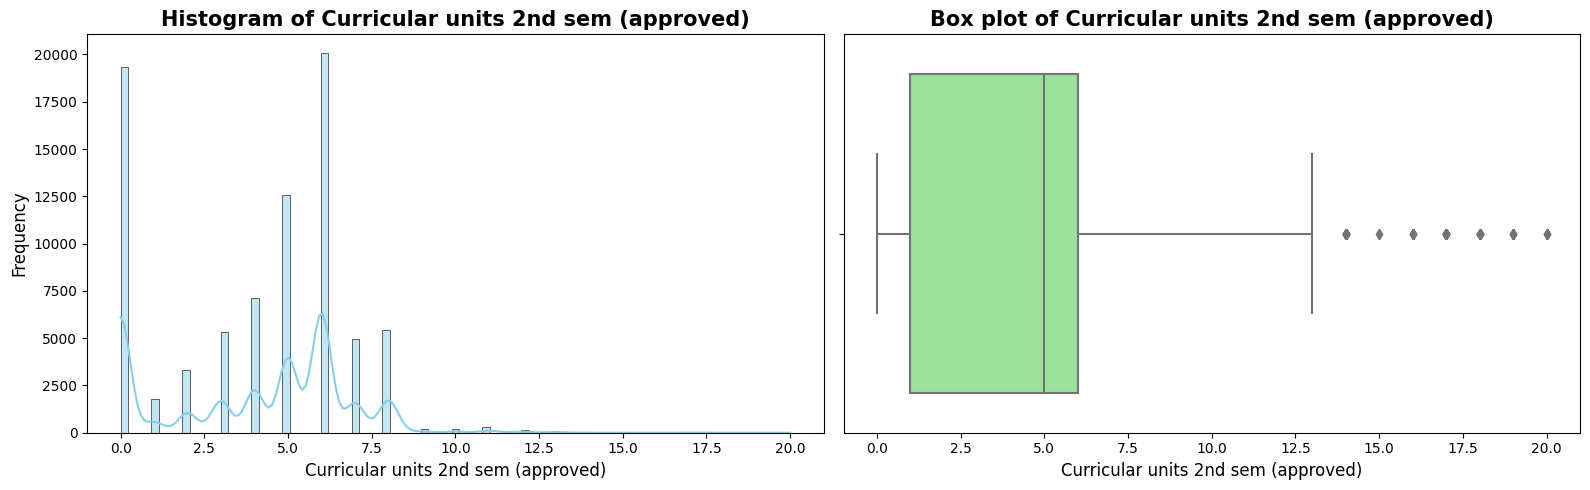

In [10]:
curr_cols = ['Curricular units 1st sem (enrolled)','Curricular units 2nd sem (enrolled)',
             'Curricular units 1st sem (evaluations)','Curricular units 2nd sem (evaluations)',
             'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)']
#
plot_numerics(df_train[curr_cols])

# Feature Engineering

In [11]:
def getFeats(df):
    
    sc=StandardScaler()
    df[num_cols]=sc.fit_transform(df[num_cols])
    
    return df

In [12]:
df_train['typ']=0
df_test['typ']=1
#
df_all=pd.concat([df_train,df_test],axis=0)
print(len(df_all))
df_all.head()

131954


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,typ
0,0,1,1,1,9238,1,1,126.0,1,1,...,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate,0
1,1,1,17,1,9238,1,1,125.0,1,19,...,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout,0
2,2,1,17,2,9254,1,1,137.0,1,3,...,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout,0
3,3,1,1,3,9500,1,1,131.0,1,19,...,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled,0
4,4,1,1,2,9500,1,1,132.0,1,19,...,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate,0


In [13]:
df_all = getFeats(df_all)
#
df_train = df_all[df_all.typ==0].reset_index(drop=True)
df_test = df_all[df_all.typ==1].reset_index(drop=True)
##
print(len(df_train))
print(len(df_test))
##
feat_cols=df_train.columns.drop(['id','typ','Target'])
X_test=df_test[feat_cols]
##
df_train.head()

80942
51012


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,typ
0,0,-0.252984,-0.906711,-0.525246,0.129322,1,-0.309314,-0.577039,-0.06757,-1.224501,...,0.031971,-0.079416,0.708791,0.498469,-0.138201,-0.159068,-0.448927,0.932576,Graduate,0
1,1,-0.252984,0.051062,-0.525246,0.129322,1,-0.309314,-0.667669,-0.06757,-0.055689,...,0.031971,0.492796,-1.454502,-1.754247,-0.138201,-0.159068,-0.448927,0.932576,Dropout,0
2,2,-0.252984,0.051062,0.284497,0.138244,1,-0.309314,0.419887,-0.06757,-1.094633,...,0.031971,-2.082156,-1.454502,-1.754247,-0.138201,1.763404,-0.663244,-0.372850,Dropout,0
3,3,-0.252984,-0.906711,1.094240,0.275434,1,-0.309314,-0.123891,-0.06757,-0.055689,...,1.251583,1.065007,1.069340,0.569417,-0.138201,-0.159068,-0.448927,0.932576,Enrolled,0
4,4,-0.252984,-0.906711,0.284497,0.275434,1,-0.309314,-0.033261,-0.06757,-0.055689,...,0.641777,1.351113,0.708791,0.589959,-0.138201,-1.478411,0.979854,0.177738,Graduate,0


In [14]:
X=df_train[feat_cols]
y=df_train['Target']
#
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Model Training

## Parameters

In [15]:
params = {'n_estimators': 8000, 
          'num_class': 3,
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'verbosity': -1,
          'random_state': 99, 
          'reg_alpha': 1.7878527151970849, 
          'reg_lambda': 1.391543710164331, 
          'colsample_bytree': 0.5, 
          'subsample': 0.5, 
          'learning_rate': 0.04, 
          'max_depth': 20, 
          'num_leaves': 70, 
          'min_child_samples': 40, 
          'min_data_per_groups': 16
         }

## Training

In [16]:
def cross_val_train(X,y,df_test,params):
    
    spl=7
    test_preds = np.zeros((len(df_test),3))
    val_preds = np.zeros((len(X),3))
    val_scores, train_scores = [],[]
    
    cv = KFold(spl, shuffle=True, random_state=42)
    
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X,y)):
        
        X_train = X.iloc[train_ind]
        y_train = y[train_ind]
        X_val = X.iloc[valid_ind]
        y_val = y[valid_ind]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    callbacks=[lgb.early_stopping(stopping_rounds=70), lgb.log_evaluation(100)]) 
        
        y_pred_trn=model.predict_proba(X_train)
        y_pred_val=model.predict_proba(X_val)
        train_acc = accuracy_score(y_train, np.argmax(y_pred_trn, axis=1))
        val_acc = accuracy_score(y_val, np.argmax(y_pred_val, axis=1))
        print("Fold:",fold, " Train R2:",np.round(train_acc,5), " Val R2:",np.round(val_acc,5))
        
        test_preds += model.predict_proba(df_test[feat_cols])/spl
        val_preds[valid_ind] = model.predict_proba(X_val)
        val_scores.append(val_acc)
        print("-"*50)
        
    return val_scores, val_preds, test_preds

In [17]:
val_scores, val_preds, test_preds=cross_val_train(X,y,df_test,params)

Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.445283
[200]	valid_0's multi_logloss: 0.431902
[300]	valid_0's multi_logloss: 0.429254
[400]	valid_0's multi_logloss: 0.428629
[500]	valid_0's multi_logloss: 0.4286
Early stopping, best iteration is:
[464]	valid_0's multi_logloss: 0.428552
Fold: 0  Train R2: 0.8838  Val R2: 0.83397
--------------------------------------------------
Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.432577
[200]	valid_0's multi_logloss: 0.42148
[300]	valid_0's multi_logloss: 0.419843
[400]	valid_0's multi_logloss: 0.419889
Early stopping, best iteration is:
[344]	valid_0's multi_logloss: 0.419711
Fold: 1  Train R2: 0.87124  Val R2: 0.84018
--------------------------------------------------
Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.452223
[200]	valid_0's multi_logloss: 0.439433
[300]	valid_0's multi_logloss: 0.436189
[

# Evaluation

In [18]:
val_preds_out = np.argmax(val_preds, axis=1)
accuracy_score(y,val_preds_out)

0.832250253267772

# Confusion Matrix

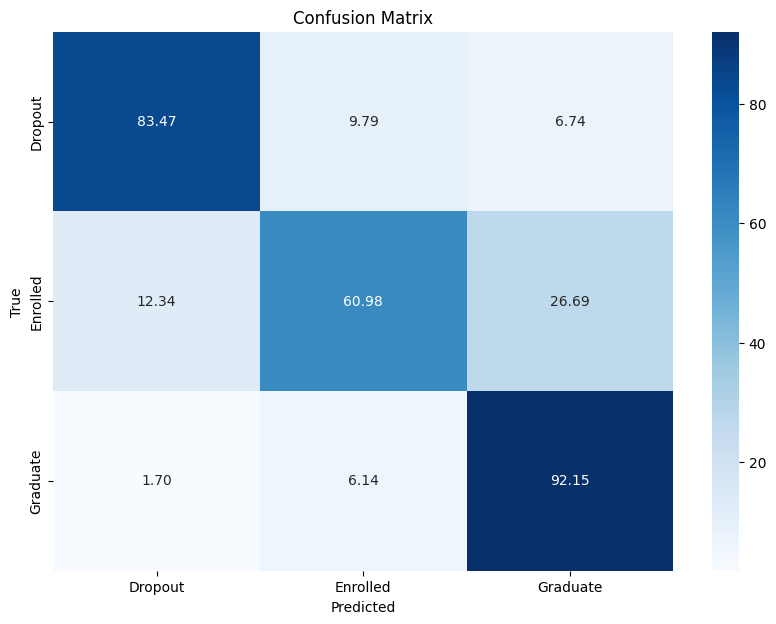

In [19]:
cm = confusion_matrix(y,val_preds_out)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prediction

In [20]:
y_test=np.argmax(test_preds, axis=1)
y_test

array([0, 2, 2, ..., 0, 0, 0])

# Submission

In [21]:
y_test=label_encoder.inverse_transform(y_test)
submission = df_test[['id']]
submission['Target']=y_test
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
